### Import Dependencies

In [59]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline


## 1. Load the Data

### 1.1 Read CSV and Initial Inspection
Load the dataset, preview sample records, and confirm basic structural details such as dimensions and column names.


In [60]:
df = pd.read_csv(r'C:\Projects\transaction_volume_capstone\data\clean\merged_data.csv', header=0)

# Convert period column to datetime and sort
df['period'] = pd.to_datetime(df['period'], format='%Y-%m')
df = df.sort_values('period')
df.set_index('period', inplace=True)



display(df.head(10))

# Display a separator
print('\n' + '_'*50 + '\n')

display(df.tail(10))

print('\n' + '_'*50 + '\n')

print(f"Rows: {df.shape[0]}  |  Columns: {df.shape[1]}")

print('\n' + '_'*50 + '\n'
      )
print("Columns:", list(df.columns))


,cpi_rate,sp500,adjusted_transactions,interest_rate
period,,,,
2019-01-01,251.712,2704.10,14,2.400
2019-02-01,252.776,2784.49,12,2.400
2019-03-01,254.202,2834.40,12,2.405
2019-04-01,255.548,2945.83,16,2.424
2019-05-01,256.092,2752.06,10,2.391
2019-06-01,256.143,2941.76,20,2.378
2019-07-01,256.571,2980.38,22,2.403
2019-08-01,256.558,2926.46,12,2.126
2019-09-01,256.759,2976.74,11,2.043



__________________________________________________



,cpi_rate,sp500,adjusted_transactions,interest_rate
period,,,,
2024-12-01,315.605,5881.63,66,4.475
2025-01-01,317.671,6040.53,37,4.330
2025-02-01,319.082,5954.50,58,4.330
2025-03-01,319.799,5611.85,71,4.330
2025-04-01,320.795,5569.06,69,4.330
2025-05-01,321.465,5911.69,57,4.330
2025-06-01,322.561,6204.95,68,4.330
2025-07-01,323.048,6339.39,56,4.330
2025-08-01,323.976,6460.26,51,4.330



__________________________________________________

Rows: 81  |  Columns: 4

__________________________________________________

Columns: ['cpi_rate', 'sp500', 'adjusted_transactions', 'interest_rate']


### 1.2 Check for Missing Values and Display Summary Statistics

In [61]:
# Check for missing values
print(df.isnull().sum())
print('\n' + '_'*50 + '\n')

# Summary statistics
print(df.describe(include='all'))
print('\n' + '_'*50 + '\n')

# Check the data types of the columns
print(df.dtypes)

cpi_rate                 0
sp500                    0
adjusted_transactions    0
interest_rate            0
dtype: int64

__________________________________________________

         cpi_rate        sp500  adjusted_transactions  interest_rate
count   81.000000    81.000000              81.000000      81.000000
mean   287.049395  4275.445432              41.296296       2.622210
std     24.696310  1052.085146              22.807041       2.102812
min    251.712000  2584.590000               8.000000       0.049000
25%    260.229000  3363.000000              21.000000       0.093000
50%    292.296000  4179.830000              43.000000       2.400000
75%    308.417000  4845.650000              57.000000       4.638000
max    324.800000  6688.460000             121.000000       5.330000

__________________________________________________

cpi_rate                 float64
sp500                    float64
adjusted_transactions      int64
interest_rate            float64
dtype: object


No missing values were identified, and data types align with expectations (float and integer types for numeric fields, datetime for `period`).


## Section 2. Exploratory Data Analysis (EDA)

### 2.1 Basic Distributions

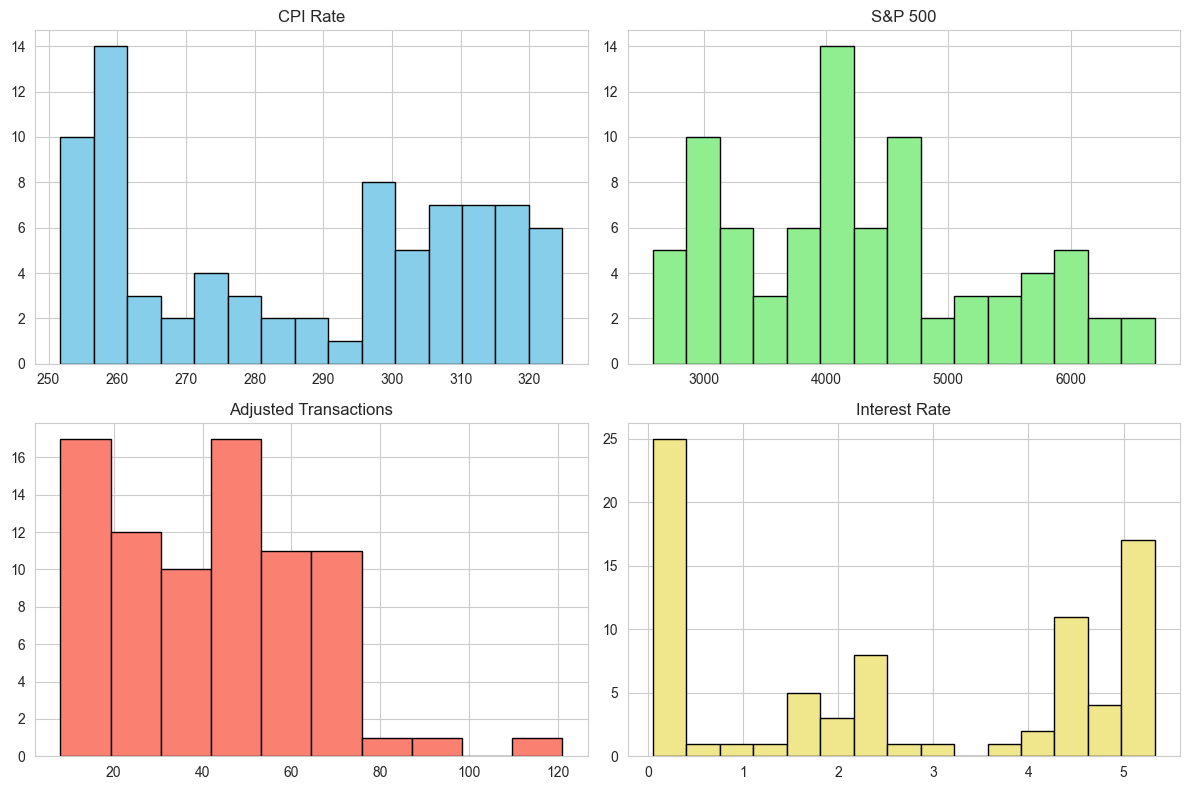

In [62]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(df['cpi_rate'], bins=15, color='skyblue', edgecolor='black')
plt.title('CPI Rate')

plt.subplot(2, 2, 2)
plt.hist(df['sp500'], bins=15, color='lightgreen', edgecolor='black')
plt.title('S&P 500')

plt.subplot(2, 2, 3)
plt.hist(df['adjusted_transactions'], bins=10, color='salmon', edgecolor='black')
plt.title('Adjusted Transactions')

plt.subplot(2, 2, 4)
plt.hist(df['interest_rate'], bins=15, color='khaki', edgecolor='black')
plt.title('Interest Rate')

plt.tight_layout()
plt.show()


CPI and S&P 500 exhibit roughly normal distributions with moderate variance, while interest rates and transaction counts show greater skewness over the observed period.


### 2.2 Correlations and Relationships

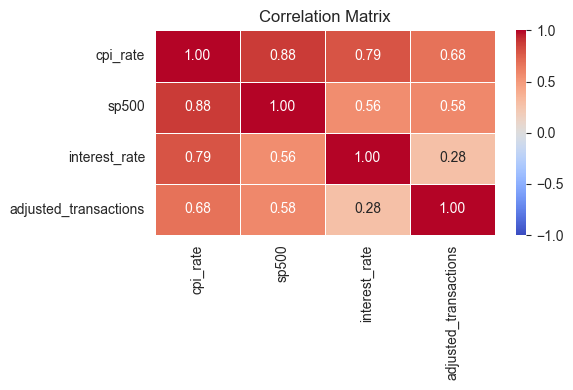

In [63]:
num_cols = ['cpi_rate', 'sp500', 'interest_rate', 'adjusted_transactions']
corr = df[num_cols].corr(method='pearson')

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1,
            cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Correlation analysis indicates moderate positive relationships between CPI, S&P 500, and adjusted transaction volume, suggesting that broader economic performance metrics may influence 1031 exchange activity.


### 2.3 Time-Series Context

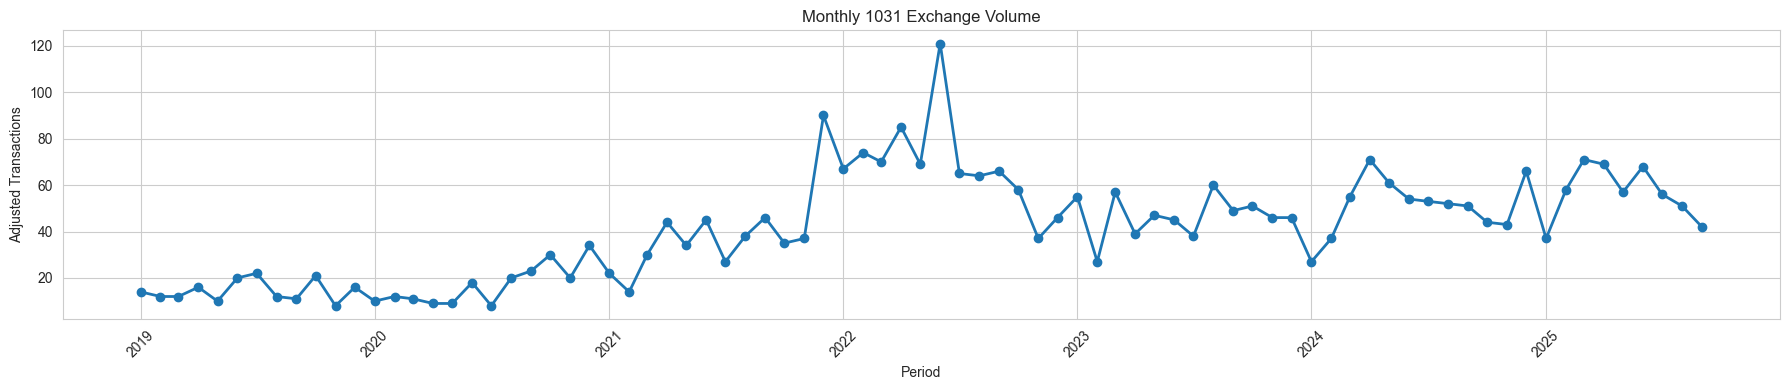

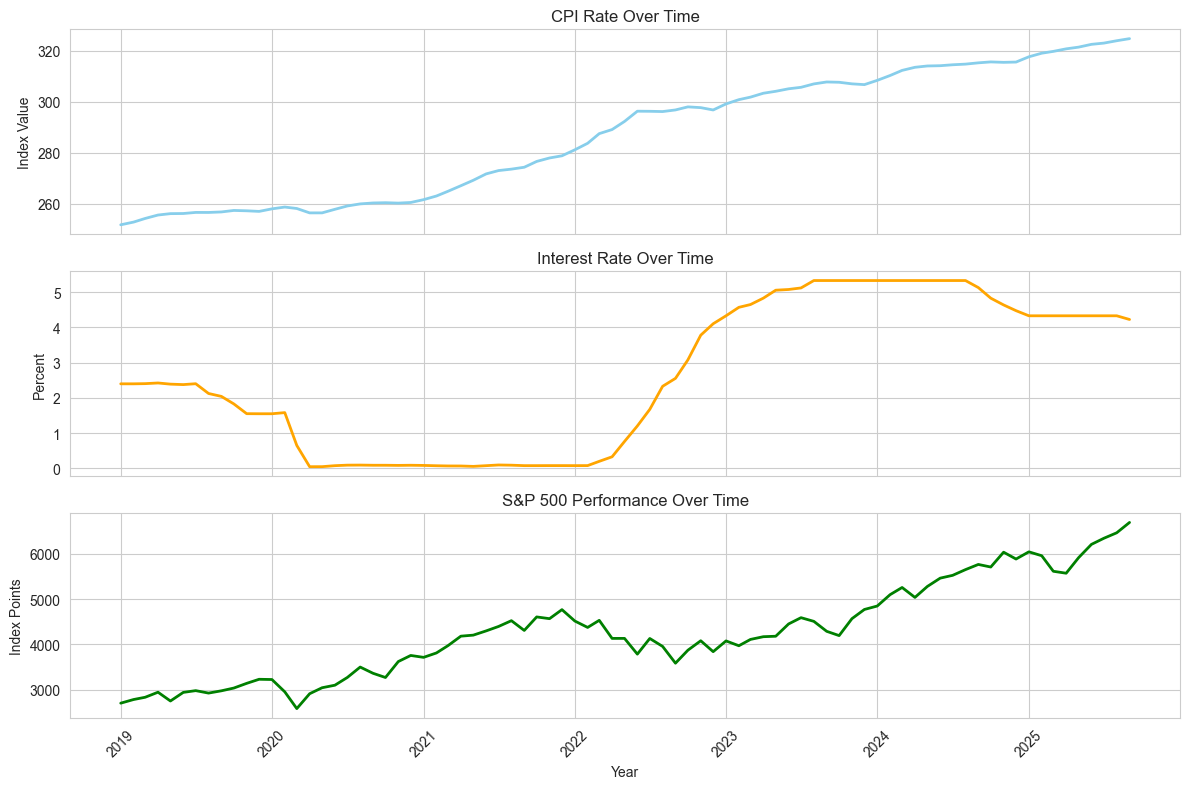

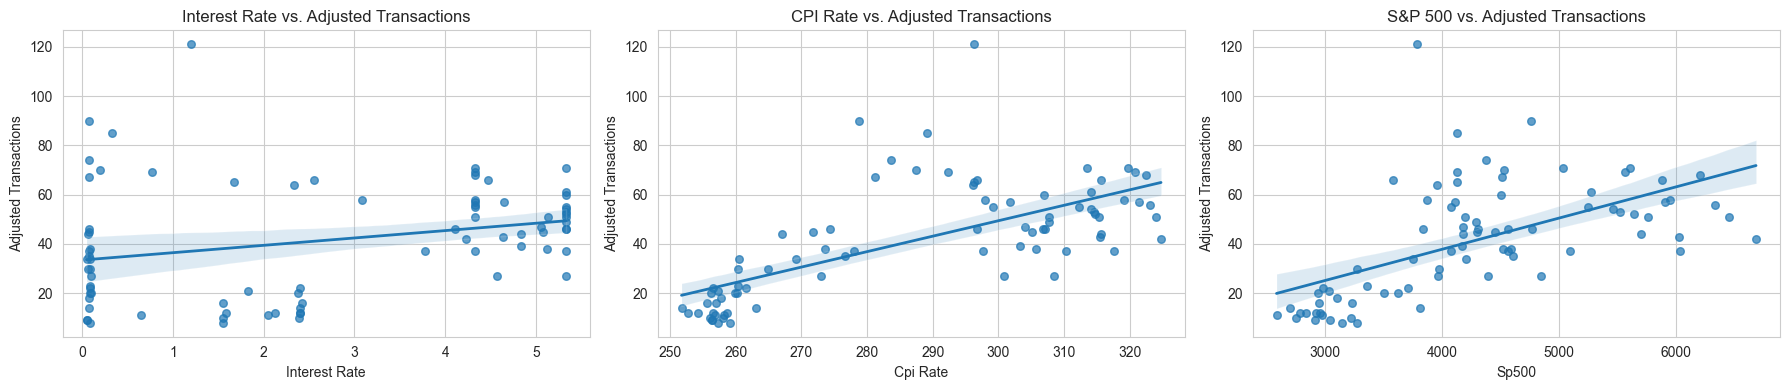

In [64]:
plt.figure(figsize=(18, 4))
plt.plot(df.index, df['adjusted_transactions'], marker='o', linewidth=2)
plt.title('Monthly 1031 Exchange Volume')
plt.xlabel('Period')
plt.ylabel('Adjusted Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df.index, df['cpi_rate'], color='skyblue', linewidth=2)
axes[0].set_title('CPI Rate Over Time')
axes[0].set_ylabel('Index Value')
axes[0].grid(True)

axes[1].plot(df.index, df['interest_rate'], color='orange', linewidth=2)
axes[1].set_title('Interest Rate Over Time')
axes[1].set_ylabel('Percent')
axes[1].grid(True)

axes[2].plot(df.index, df['sp500'], color='green', linewidth=2)
axes[2].set_title('S&P 500 Performance Over Time')
axes[2].set_ylabel('Index Points')
axes[2].grid(True)

plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




fig, axes = plt.subplots(1, 3, figsize=(18, 4))

pairs = [
    ('interest_rate', 'adjusted_transactions'),
    ('cpi_rate', 'adjusted_transactions'),
    ('sp500', 'adjusted_transactions')
]

for ax, (x, y) in zip(axes, pairs):
    sns.regplot(x=df[x], y=df[y],
                ax=ax,
                scatter_kws={'s':30, 'alpha':0.7},
                line_kws={'linewidth':2})
    ax.set_xlabel(x.replace('_',' ').title())
    ax.set_ylabel('Adjusted Transactions')
    axes[0].set_title('Interest Rate vs. Adjusted Transactions')
    axes[1].set_title('CPI Rate vs. Adjusted Transactions')
    axes[2].set_title('S&P 500 vs. Adjusted Transactions')


plt.tight_layout()
plt.show()


##### Summary of Insights

- Transaction volume fluctuates month-to-month, peaking around 2022, possibly reflecting post-pandemic investment activity.

- CPI and S&P 500 both show steady upward trends from 2019–2025, while interest rates remained low through 2021 before rising sharply in 2023.

- Exchange volume shows moderate correlation with CPI and S&P 500, suggesting that market conditions and inflation trends influence activity.

- Interest rates display a weaker but positive relationship with transaction volume.

- These findings help identify which features may be most relevant for future predictive modeling.


## Section 3. Feature Selection and Justification

### 3.1 Choose Features and Target

Input features: ```cpi_rate```, ```sp500```, ```interest_rate```

Target feature: ```adjusted_transactions```

### 3.2 Define X and Y

In [65]:
# Define X and y using selected features
X = df[['cpi_rate', 'sp500', 'interest_rate']]
y = df['adjusted_transactions']


## Section 4. Train a Regression Model Using Multiple Linear Regression

### 4.1 Train/Test Split

In [66]:
# 80/20 split for train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)


### 4.2 Create and Train Model

In [67]:
# Create and train the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 4.3 Predict and Evaluate the Model

In [68]:
# Make predictions on the test set
y_pred = linreg.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


R² Score: 0.7880
Mean Absolute Error (MAE): 7.60
Root Mean Squared Error (RMSE): 9.04


### 4.4 Multiple Linear Regression Actual vs. Predicted Plot

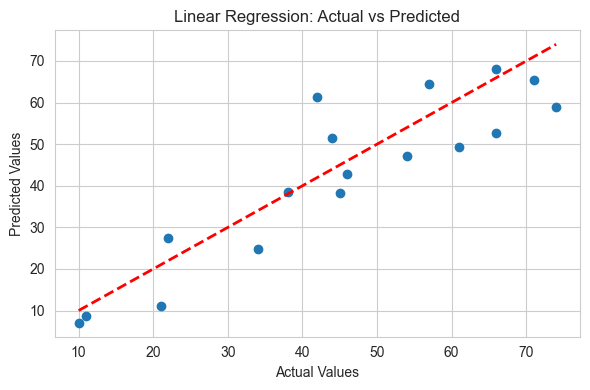

In [81]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()



## Section 5. Random Forest Regression

### 5.1 Set up the Random Forest Model

In [69]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=123,
    n_jobs=-1
)


### 5.2 Fit the model

In [70]:
rf_model.fit(X_train, y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 5.3 Evaluate Random Forest performance

In [71]:
# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
rf_mae_train = mean_absolute_error(y_train, y_train_pred_rf)
rf_mae_test  = mean_absolute_error(y_test, y_test_pred_rf)

rf_mse_train = mean_squared_error(y_train, y_train_pred_rf)
rf_mse_test  = mean_squared_error(y_test, y_test_pred_rf)

rf_rmse_train = rf_mse_train ** 0.5
rf_rmse_test  = rf_mse_test ** 0.5

rf_r2_train = r2_score(y_train, y_train_pred_rf)
rf_r2_test  = r2_score(y_test, y_test_pred_rf)

print("Random Forest Regression Performance")
print("------------------------------------")
print(f"Train MAE:  {rf_mae_train:.2f}")
print(f"Test MAE:   {rf_mae_test:.2f}")
print(f"Train RMSE: {rf_rmse_train:.2f}")
print(f"Test RMSE:  {rf_rmse_test:.2f}")
print(f"Train R²:   {rf_r2_train:.3f}")
print(f"Test R²:    {rf_r2_test:.3f}")


Random Forest Regression Performance
------------------------------------
Train MAE:  3.69
Test MAE:   7.66
Train RMSE: 5.64
Test RMSE:  9.17
Train R²:   0.942
Test R²:    0.782


### 5.4 Random Forest Regression Actual vs. Predicted Plot

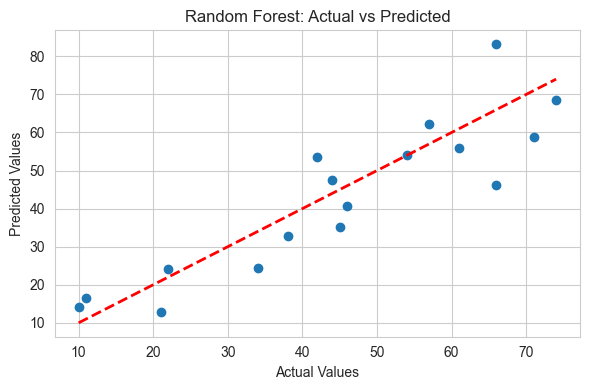

In [82]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_rf)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()


### 5.5 Feature Importance

,feature,importance
0,cpi_rate,0.704686
1,sp500,0.198938
2,interest_rate,0.096375


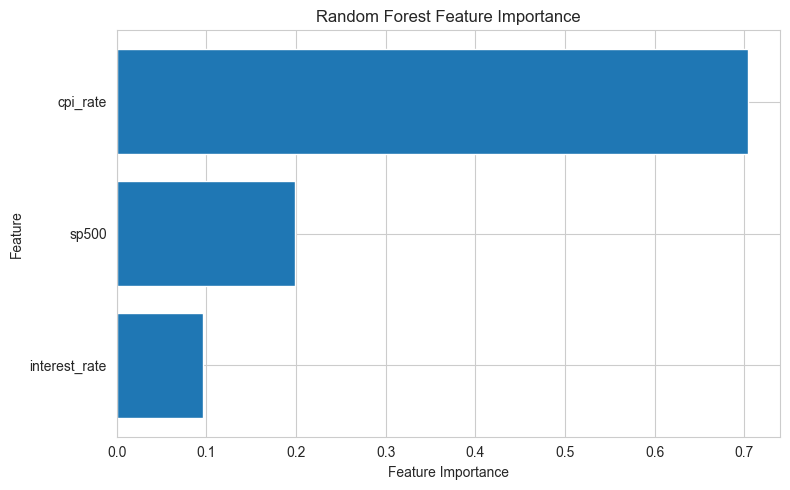

In [79]:
# Get feature importances directly from the random forest model
importances = rf_model.feature_importances_

# Use your original feature names from X
feature_names = X.columns

# Create a DataFrame for display
feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feature_importance_df.head(15)

display(feature_importance_df)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # most important at the top
plt.tight_layout()
plt.show()

